PINN_PENDULO_LUIS_T_MU.ipynb (2023.09.30)

In [1]:
### Import all what you need:
import torch
import torch.nn as nn
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

In [3]:
# Save in a variable the device cuda(Linux and Windows), mps(Apple) or cpu, you will use for training:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
torch.cuda.current_device()

0

In [5]:
#Definition of the physical constants and hyperparameters:
d, w0 = 2, 20
mu, k = 2*d, w0**2
learning_rate =  1e-4         # learning rate
lambda1, lambda2 = 1e-4, 1e-4 # loss term hyperparameters
epochs = 20001

### Generate initial training points:


In [6]:
#### Initial condition 1: t and mu training points generation 
point_resolution = 40

In [7]:
mu_range = (1,10)

In [8]:
test = (*mu_range, point_resolution)

In [9]:
#torch.linspace(*test)

In [10]:
ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)],-1)
#ic1_t_mu = torch.stack([torch.zeros(point_resolution), torch.linspace(1,10, point_resolution)],-1).requires_grad_(True).to(device)
#ic1_t_mu

In [11]:
ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)#.to(device)
print(ic1_t_mu.shape, ic1_scope.shape)

torch.Size([40, 2]) torch.Size([40, 1])


In [12]:
#ic1_scope

#### Initial condition 2: t and mu training points generation:

In [13]:
ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)], -1)
#ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True).to(device), torch.linspace(1,10, point_resolution).requires_grad_(True).to(device)], -1)
ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)#.to(device)
#ic2_t_mu

In [14]:
#ic2_scope

#### Generation of physical domain training points: 

In [15]:
### Generate domain physic loss sample points:
physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True), torch.linspace(1,10, point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
#physic_in_t_mu = [torch.linspace(1e-2,1, point_resolution).requires_grad_(True).to(device), torch.linspace(1,10, point_resolution).requires_grad_(True).to(device)] # Mejora: se puede utilizar torch.rand
physic_in_t_mu

[tensor([0.0100, 0.0354, 0.0608, 0.0862, 0.1115, 0.1369, 0.1623, 0.1877, 0.2131,
         0.2385, 0.2638, 0.2892, 0.3146, 0.3400, 0.3654, 0.3908, 0.4162, 0.4415,
         0.4669, 0.4923, 0.5177, 0.5431, 0.5685, 0.5938, 0.6192, 0.6446, 0.6700,
         0.6954, 0.7208, 0.7462, 0.7715, 0.7969, 0.8223, 0.8477, 0.8731, 0.8985,
         0.9238, 0.9492, 0.9746, 1.0000], requires_grad=True),
 tensor([ 1.0000,  1.2308,  1.4615,  1.6923,  1.9231,  2.1538,  2.3846,  2.6154,
          2.8462,  3.0769,  3.3077,  3.5385,  3.7692,  4.0000,  4.2308,  4.4615,
          4.6923,  4.9231,  5.1538,  5.3846,  5.6154,  5.8462,  6.0769,  6.3077,
          6.5385,  6.7692,  7.0000,  7.2308,  7.4615,  7.6923,  7.9231,  8.1538,
          8.3846,  8.6154,  8.8462,  9.0769,  9.3077,  9.5385,  9.7692, 10.0000],
        requires_grad=True)]

In [16]:
physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)#.to(device)
physic_domain_t_mu

tensor([[1.0000e-02, 1.0000e+00],
        [1.0000e-02, 1.2308e+00],
        [1.0000e-02, 1.4615e+00],
        ...,
        [1.0000e+00, 9.5385e+00],
        [1.0000e+00, 9.7692e+00],
        [1.0000e+00, 1.0000e+01]], grad_fn=<ViewBackward0>)

In [17]:
physic_domain_t_mu.size()

torch.Size([1600, 2])

#### Generation of testing points:

In [18]:
point_resolution_test = 100

In [19]:
# get testing locations
test_in_t_mu = [torch.linspace(0,1,point_resolution_test), torch.linspace(1,10,point_resolution_test) ]
test_domain_t_mu = torch.stack(torch.meshgrid(*test_in_t_mu, indexing='ij'), -1).view(-1, 2)
test_domain_t_mu.size()

torch.Size([10000, 2])

In [20]:
### Definition of the Fully Connected Neural Network Class:
# define NN
class FCN(nn.Module):
    "Defines a fully-connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [21]:
model = FCN(2,1,64,4)
#model.parameters

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)
#optimizer

## Training (one epoch):

In [23]:
optimizer.zero_grad()

### Compute the "data loss":

Loss term from the initial condition 1 (u):

In [24]:
ic1_predicted= model(ic1_t_mu)
#ic1_predicted

In [25]:
loss_ic1 = torch.mean((ic1_predicted - ic1_scope)**2)
loss_ic1

tensor(0.7632, grad_fn=<MeanBackward0>)

Loss term from the initial condition 2 (du/dt):

In [26]:
du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]

In [27]:
du_dtdmu_initial.size()

torch.Size([40, 2])

In [28]:
loss_ic2 = torch.mean((ic2_du_dt- ic2_scope)**2)
loss_ic2

tensor(8.0313e-05, grad_fn=<MeanBackward0>)

### Compute the "physics loss":

In [29]:
physic_domain_predicted = model(physic_domain_t_mu)
physic_domain_predicted.size()

torch.Size([1600, 1])

In [30]:
physic_domain_du_dt = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
physic_domain_du_dt

tensor([[-0.0213,  0.0193],
        [-0.0204,  0.0203],
        [-0.0193,  0.0203],
        ...,
        [ 0.0085,  0.0018],
        [ 0.0087,  0.0016],
        [ 0.0088,  0.0015]], grad_fn=<MmBackward0>)

In [31]:
physic_domain_d2u_d2t = torch.autograd.grad(outputs = physic_domain_du_dt, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dt), create_graph= True)[0]
physic_domain_d2u_d2t

tensor([[ 0.0323,  0.0099],
        [ 0.0297,  0.0064],
        [ 0.0269,  0.0042],
        ...,
        [ 0.0030, -0.0001],
        [ 0.0031, -0.0002],
        [ 0.0031, -0.0002]], grad_fn=<MmBackward0>)

In [32]:
loss_differential_equation = torch.mean( (physic_domain_d2u_d2t + physic_domain_t_mu[:,1:2] * physic_domain_du_dt + k * physic_domain_predicted )**2)
loss_differential_equation

tensor(2629.2915, grad_fn=<MeanBackward0>)

In [33]:
loss = loss_ic1 + lambda1 * loss_ic2 + lambda2 * loss_differential_equation
loss

tensor(1.0261, grad_fn=<AddBackward0>)

In [34]:
loss.backward()

In [35]:
optimizer.step()

#### Test points

In [38]:
test_predicted = model(test_domain_t_mu)
test_predicted.size()

torch.Size([10000, 1])

In [41]:
test_predicted

tensor([[0.0673],
        [0.0687],
        [0.0700],
        ...,
        [0.1351],
        [0.1353],
        [0.1354]], grad_fn=<AddmmBackward0>)

<function matplotlib.pyplot.show(close=None, block=None)>

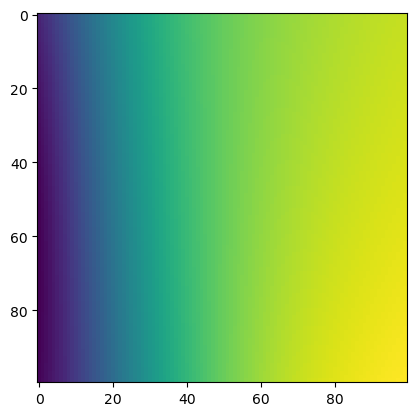

In [42]:
plt.figure()
plt.imshow(test_predicted.reshape(100,100).detach())
plt.show

AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

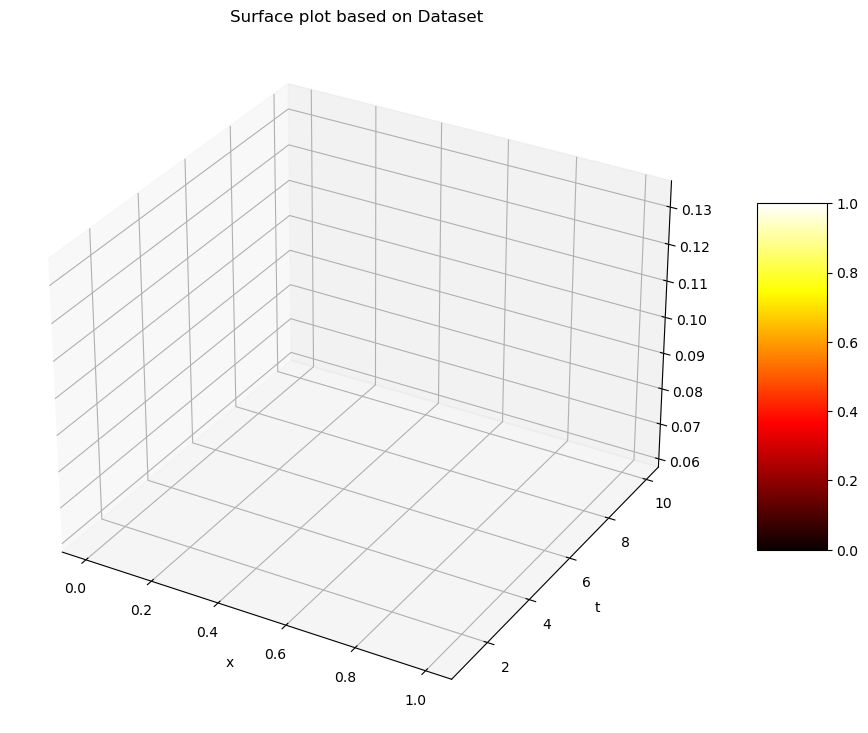

In [44]:
# Creating 3D figure:
fig = plt.figure(figsize =(14, 9)) 
ax = plt.axes(projection ='3d') 

# Creating color map 
my_cmap = plt.get_cmap('hot') 

# Creating plot 
surf = ax.plot_surface(test_domain_t_mu[:,0:1].detach().numpy(), test_domain_t_mu[:,1:2].detach().numpy(), test_predicted.detach().numpy(), cmap = my_cmap, edgecolor ='none') 

fig.colorbar(surf, ax = ax, shrink = 0.5, aspect = 5) 

ax.set_title('Surface plot based on Dataset') 
plt.xlabel("x")
plt.ylabel("t")
plt.zlabel("u")

# show plot 
plt.show() 